In [ ]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive/machine-learning/projects/arrythmia

data


In [ ]:
%cd drive/My\ Drive/machine-learning/projects/arrythmia

/content/drive/My Drive/machine-learning/projects/arrythmia


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('./data/arrhythmia.csv')

In [ ]:
data.shape

(452, 280)

In [ ]:
data.head()

,age,sex,height,weight,QRSduration,PRinterval,Q-Tinterval,Tinterval,Pinterval,QRS,T,P,QRST,J,heartrate,chDI_Qwave,chDI_Rwave,chDI_Swave,chDI_RPwave,chDI_SPwave,chDI_intrinsicReflecttions,chDI_RRwaveExists,chDI_DD_RRwaveExists,chDI_RPwaveExists,chDI_DD_RPwaveExists,chDI_RTwaveExists,chDI_DD_RTwaveExists,chDII_Qwave,chDII_Rwave,chDII_Swave,chDII_RPwave,chDII_SPwave,chDII_intrinsicReflecttions,chDII_RRwaveExists,chDII_DD_RRwaveExists,chDII_RPwaveExists,chDII_DD_RPwaveExists,chDII_RTwaveExists,chDII_DD_RTwaveExists,chDIII_Qwave,...,chV3_QwaveAmp,chV3_RwaveAmp,chV3_SwaveAmp,chV3_RPwaveAmp,chV3_SPwaveAmp,chV3_PwaveAmp,chV3_TwaveAmp,chV3_QRSA,chV3_QRSTA,chV4_JJwaveAmp,chV4_QwaveAmp,chV4_RwaveAmp,chV4_SwaveAmp,chV4_RPwaveAmp,chV4_SPwaveAmp,chV4_PwaveAmp,chV4_TwaveAmp,chV4_QRSA,chV4_QRSTA,chV5_JJwaveAmp,chV5_QwaveAmp,chV5_RwaveAmp,chV5_SwaveAmp,chV5_RPwaveAmp,chV5_SPwaveAmp,chV5_PwaveAmp,chV5_TwaveAmp,chV5_QRSA,chV5_QRSTA,chV6_JJwaveAmp,chV6_QwaveAmp,chV6_RwaveAmp,chV6_SwaveAmp,chV6_RPwaveAmp,chV6_SPwaveAmp,chV6_PwaveAmp,chV6_TwaveAmp,chV6_QRSA,chV6_QRSTA,class
0,75,0,190,80,91,193,371,174,121,-16,13.0,64.0,-2.0,NaN,63.0,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,...,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,0
1,56,1,165,64,81,174,401,149,39,25,37.0,-17.0,31.0,NaN,53.0,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,...,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,0
2,54,0,172,95,138,163,386,185,102,96,34.0,70.0,66.0,23.0,75.0,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,...,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,0
3,55,0,175,94,100,202,380,179,143,28,11.0,-5.0,20.0,NaN,71.0,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,...,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,13.0,61.0,3.0,NaN,NaN,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,...,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,0


In [ ]:
data.describe()

,age,sex,height,weight,QRSduration,PRinterval,Q-Tinterval,Tinterval,Pinterval,QRS,T,P,QRST,J,heartrate,chDI_Qwave,chDI_Rwave,chDI_Swave,chDI_RPwave,chDI_SPwave,chDI_intrinsicReflecttions,chDI_RRwaveExists,chDI_DD_RRwaveExists,chDI_RPwaveExists,chDI_DD_RPwaveExists,chDI_RTwaveExists,chDI_DD_RTwaveExists,chDII_Qwave,chDII_Rwave,chDII_Swave,chDII_RPwave,chDII_SPwave,chDII_intrinsicReflecttions,chDII_RRwaveExists,chDII_DD_RRwaveExists,chDII_RPwaveExists,chDII_DD_RPwaveExists,chDII_RTwaveExists,chDII_DD_RTwaveExists,chDIII_Qwave,...,chV3_QwaveAmp,chV3_RwaveAmp,chV3_SwaveAmp,chV3_RPwaveAmp,chV3_SPwaveAmp,chV3_PwaveAmp,chV3_TwaveAmp,chV3_QRSA,chV3_QRSTA,chV4_JJwaveAmp,chV4_QwaveAmp,chV4_RwaveAmp,chV4_SwaveAmp,chV4_RPwaveAmp,chV4_SPwaveAmp,chV4_PwaveAmp,chV4_TwaveAmp,chV4_QRSA,chV4_QRSTA,chV5_JJwaveAmp,chV5_QwaveAmp,chV5_RwaveAmp,chV5_SwaveAmp,chV5_RPwaveAmp,chV5_SPwaveAmp,chV5_PwaveAmp,chV5_TwaveAmp,chV5_QRSA,chV5_QRSTA,chV6_JJwaveAmp,chV6_QwaveAmp,chV6_RwaveAmp,chV6_SwaveAmp,chV6_RPwaveAmp,chV6_SPwaveAmp,chV6_PwaveAmp,chV6_TwaveAmp,chV6_QRSA,chV6_QRSTA,class
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,444.000000,430.000000,451.000000,76.000000,451.000000,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.00000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,36.150901,48.913953,36.716186,-13.592105,74.463415,5.628319,51.628319,20.920354,0.141593,0.0,30.035398,0.002212,0.011062,0.011062,0.004425,0.004425,0.008850,5.619469,54.336283,20.59292,0.433628,0.150442,31.637168,0.017699,0.028761,0.002212,0.004425,0.004425,0.015487,16.026549,...,-0.653540,8.039602,-10.150664,0.032965,-0.013496,0.226770,3.894690,-8.269027,32.422788,0.001106,-0.297566,11.839381,-7.034513,0.025664,-0.002876,0.547788,2.535841,10.081195,33.328540,-0.285398,-0.277212,11.369912,-3.607522,0.016814,0.0,0.546681,1.722124,17.840044,32.871460,-0.302434,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230,0.542035
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,57.858255,29.346409,36.020725,127.220248,13.870684,10.650001,18.249901,20.541728,1.569483,0.0,10.046393,0.047036,0.104708,0.104708,0.066445,0.066445,0.093759,11.220680,17.248213,21.06105,3.093161,2.692591,9.624951,0.132002,0.167319,0.047036,0.066445,0.066445,0.123615,21.906457,...,3.414085,5.279719,7.066568,0.390403,0.264398,0.548988,2.990809,32.157008,37.362289,1.015566,1.758544,5.917391,5.061472,0.166763,0.046287,0.426941,2.429776,25.074695,34.361665,0.675060,0.992472,4.793656,2.850633,0.275907,0.0,0.370548,1.708190,16.445472,24.421643,0.603551,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927,0.498782
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,-177.000000,-170.000000,-135.000000,-179.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-32.900000,0.000000,-48.400000,0.000000,-5.600000,-3.100000,-11.800000,-242.400000,-146.200000,-3.200000,-20.400000,0.000000,-42.900000,0.000000,-0.900000,-2.600000,-8.

In [ ]:
data.isnull().sum()

age              0
sex              0
height           0
weight           0
QRSduration      0
                ..
chV6_PwaveAmp    0
chV6_TwaveAmp    0
chV6_QRSA        0
chV6_QRSTA       0
class            0
Length: 280, dtype: int64

Data Preprocessing

In [ ]:
def fillEmpty(data, uniVal):
    categorical = []
    for i in range(0,data.shape[1]):     #to differentiate categorical and continuous
        temp = []
        temp = np.unique(data[data.columns[i]])
        if len(temp) <= uniVal:
            categorical.append(data.columns[i])
    continuous = []
    continuous  = list(set(data.columns) - set(categorical))
    for j in continuous:
        data[j] = data[j].fillna((data[j].mean()))
    for k in categorical:
        data[k] = data[k].fillna((data[k].mode()[0]))
    return pd.DataFrame(data)

In [ ]:
uniVal = 10
data = fillEmpty(data,uniVal) 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import minmax_scale
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

In [ ]:
def accuracyKnn(X_train,X_test,y_train,y_test):
    classifierknn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
    classifierknn.fit(X_train,y_train)
    y_predknn = classifierknn.predict(X_test)
    accuracy = accuracy_score(y_test, y_predknn)
    print("KNN: {}".format(accuracy))
    return accuracy

def accuracyDecision(X_train,X_test,y_train,y_test):
    classifierdt = DecisionTreeClassifier(criterion='entropy', random_state=0)
    classifierdt.fit(X_train,y_train)
    y_preddt = classifierdt.predict(X_test)
    accuracy1 = accuracy_score(y_test, y_preddt)
    print("DT: {}".format(accuracy1))
    return accuracy1

def accuracySVM(X_train,X_test,y_train,y_test):
    classifierSVCl=SVC(kernel='linear',random_state=0) #52.5%, 57.4% with imputation and LDA
    classifierSVCr=SVC(kernel='rbf',random_state=0)
    classifierSVCl.fit(X_train,y_train)
    y_predsvm = classifierSVCl.predict(X_test)
    accuracy2 = accuracy_score(y_test, y_predsvm)
    print("SVM: {}".format(accuracy2))
    return accuracy2

def accuracyRF(X_train,X_test,y_train,y_test):
    classifierrf=RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
    classifierrf.fit(X_train,y_train)
    y_predrf = classifierrf.predict(X_test)
    accuracy3 = accuracy_score(y_test, y_predrf)
    print("RF: {}".format(accuracy3))
    return accuracy3

def accuracyLoR(X_train,X_test,y_train,y_test):
    classifierlor=LogisticRegression()
    classifierlor.fit(X_train,y_train)
    y_predlor = classifierlor.predict(X_test)
    accuracy4 = accuracy_score(y_test, y_predlor)
    print("LoR: {}".format(accuracy4))
    return accuracy4

Filteration

In [ ]:
def removeConstantFeature(X_train,X_test):
    constant_features = [
        feat for feat in X_train.columns if X_train[feat].std() == 0
    ]
    X_train.drop(labels=constant_features, axis=1, inplace=True)
    X_test.drop(labels=constant_features, axis=1, inplace=True)
    return X_train,X_test
    
def removeQuasiConstant(X_train, X_test, varianceAllowed):
    sel = VarianceThreshold(threshold=varianceAllowed)
    sel.fit(X_train)
    features_to_keep = X_train.columns[sel.get_support()]
    X_train = sel.transform(X_train)
    X_test = sel.transform(X_test)
    X_train= pd.DataFrame(X_train)
    X_train.columns = features_to_keep
    X_test= pd.DataFrame(X_test)
    X_test.columns = features_to_keep
    return X_train, X_test
    
def removeDuplicateFeature(X_train, X_test):
    duplicated_feat = []
    for i in range(0, len(X_train.columns)):
        if i % 10 == 0:  # this helps me understand how the loop is going
            print(i)
        col_1 = X_train.columns[i]
        for col_2 in X_train.columns[i + 1:]:
            if X_train[col_1].equals(X_train[col_2]):
                duplicated_feat.append(col_2)
    len(duplicated_feat)
    X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
    X_test.drop(labels=duplicated_feat, axis=1, inplace=True)
    return X_train, X_test

def removeCorelatedFeature(X_train, X_test, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = X_train.corr(method='spearman')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    col_corr
    X_train_corr = X_train.copy()
    X_test_corr = X_test.copy()
    X_train_corr.drop(labels=col_corr, axis=1, inplace=True)
    X_test_corr.drop(labels=col_corr, axis=1, inplace=True)
    return X_train_corr, X_test_corr

def removeUnivariate(X_train, X_test, y_train, y_test):
    roc_values = []
    for feature in X_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    roc_values = pd.Series(roc_values)
    roc_values.index = X_train.columns
    roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))
    selected_feat = roc_values[roc_values>0.5]
    features = selected_feat.index
    notneeded = [x for x in X_train.columns if x not in features]
    X_train.drop(labels=notneeded, axis=1, inplace=True)
    X_test.drop(labels=notneeded, axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

def removeLasso(X_train,X_test, y_train, y_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
    sel_.fit(scaler.transform(X_train), y_train)
    
    X_train_lasso = pd.DataFrame(sel_.transform(X_train))
    X_test_lasso = pd.DataFrame(sel_.transform(X_test))
    
    X_train_lasso.columns = X_train.columns[(sel_.get_support())]
    X_test_lasso.columns = X_train.columns[(sel_.get_support())]
    return X_train_lasso, X_test_lasso

Splitting dataset

In [ ]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['class'], axis=1),data['class'],test_size=0.3,random_state=0)
X_train.shape, X_test.shape

((316, 279), (136, 279))

In [ ]:
y_true = [ y for i,y in enumerate(y_test)]
print(y_true)

[1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]


In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
accKnn = []
accDecision = []
accSVM=[]
accRF=[]
accNN=[]
accLoR=[]
accKnn.append(accuracyKnn(X_train,X_test,y_train,y_test))
accDecision.append(accuracyDecision(X_train,X_test,y_train,y_test))
accSVM.append(accuracySVM(X_train,X_test,y_train,y_test))
accRF.append(accuracyRF(X_train,X_test,y_train,y_test))
accLoR.append(accuracyLoR(X_train,X_test,y_train,y_test))
print(X_train.shape)
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

KNN: 0.6323529411764706
DT: 0.6838235294117647
SVM: 0.6397058823529411
RF: 0.7205882352941176
LoR: 0.6470588235294118
(316, 279)


Constant Features

In [ ]:
sel = VarianceThreshold(threshold=0)
sel.fit(X_train)  # fit finds the features with zero variance
sum(sel.get_support())

257

In [ ]:
X_train, X_test = removeConstantFeature(X_train,X_test)
print(X_train.shape)
accKnn.append(accuracyKnn(X_train,X_test,y_train,y_test))
accDecision.append(accuracyDecision(X_train,X_test,y_train,y_test))
accSVM.append(accuracySVM(X_train,X_test,y_train,y_test))
accRF.append(accuracyRF(X_train,X_test,y_train,y_test))
accLoR.append(accuracyLoR(X_train,X_test,y_train,y_test))

(316, 257)
KNN: 0.6323529411764706
DT: 0.6911764705882353
SVM: 0.6397058823529411
RF: 0.7058823529411765
LoR: 0.6544117647058824


Quasi constant features

In [ ]:
sel = VarianceThreshold(
    threshold=0.01)  # 0.01 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance
sum(sel.get_support())

214

In [ ]:
print(len([x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]))

43


In [ ]:
varianceAllowed = 0.01
X_train_quasi, X_test_quasi = removeQuasiConstant(X_train, X_test, varianceAllowed)
print(X_train_quasi.shape)
accKnn.append(accuracyKnn(X_train_quasi,X_test_quasi,y_train,y_test))
accDecision.append(accuracyDecision(X_train_quasi,X_test_quasi,y_train,y_test))
accSVM.append(accuracySVM(X_train_quasi,X_test_quasi,y_train,y_test))
accRF.append(accuracyRF(X_train_quasi,X_test_quasi,y_train,y_test))
accLoR.append(accuracyLoR(X_train_quasi,X_test_quasi,y_train,y_test))

(316, 214)
KNN: 0.6323529411764706
DT: 0.6838235294117647
SVM: 0.6397058823529411
RF: 0.75
LoR: 0.6470588235294118


Duplicated features

In [ ]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    #if i % 10 == 0:  # this helps me understand how the loop is going
        #print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
print(len(set(duplicated_feat)))

2


In [ ]:
X_train_dup, X_test_dup = removeDuplicateFeature(X_train_quasi, X_test_quasi)
print(X_train_dup.shape)
accKnn.append(accuracyKnn(X_train_dup,X_test_dup,y_train,y_test))
accDecision.append(accuracyDecision(X_train_dup,X_test_dup,y_train,y_test))
accSVM.append(accuracySVM(X_train_dup,X_test_dup,y_train,y_test))
accRF.append(accuracyRF(X_train_dup,X_test_dup,y_train,y_test))
accLoR.append(accuracyLoR(X_train_dup,X_test_dup,y_train,y_test))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
(316, 214)
KNN: 0.6323529411764706
DT: 0.6838235294117647
SVM: 0.6397058823529411
RF: 0.75
LoR: 0.6470588235294118


Correlation- Spearman

In [ ]:
# build a dataframe with the correlation(Spearman) between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = X_train.corr(method='spearman')
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,chDI_RPwave,chDI_RPwaveAmp,0.999997
1,chDI_RPwaveAmp,chDI_RPwave,0.999997
2,chV2_SPwave,chV2_SPwaveAmp,0.999995
3,chV2_SPwaveAmp,chV2_SPwave,0.999995
4,chV3_RPwave,chV3_RPwaveAmp,0.999987


In [ ]:
threshold = 0.8
X_train_corr, X_test_corr = removeCorelatedFeature(X_train_dup, X_test_dup, threshold)
print(X_train_corr.shape)
accKnn.append(accuracyKnn(X_train_corr,X_test_corr,y_train,y_test))
accDecision.append(accuracyDecision(X_train_corr,X_test_corr,y_train,y_test))
accSVM.append(accuracySVM(X_train_corr,X_test_corr,y_train,y_test))
accRF.append(accuracyRF(X_train_corr,X_test_corr,y_train,y_test))
accLoR.append(accuracyLoR(X_train_corr,X_test_corr,y_train,y_test))

(316, 147)
KNN: 0.6323529411764706
DT: 0.6544117647058824
SVM: 0.6838235294117647
RF: 0.7058823529411765
LoR: 0.6911764705882353


Univariate features with DT

In [ ]:
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train_corr.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train_corr[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test_corr[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

In [ ]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train_corr.columns
roc_values.sort_values(ascending=False)

chV2_Rwave        0.683268
chDI_Swave        0.666884
height            0.658529
chV1_Swave        0.642578
chV4_RwaveAmp     0.630208
                    ...   
chDII_Rwave       0.476888
chV4_RPwave       0.469944
chDI_JJwaveAmp    0.468967
chAVR_RPwave      0.450738
chV3_QRSA         0.435981
Length: 147, dtype: float64

(316, 112)
KNN: 0.6470588235294118
DT: 0.6617647058823529
SVM: 0.6397058823529411
RF: 0.6985294117647058
LoR: 0.7279411764705882


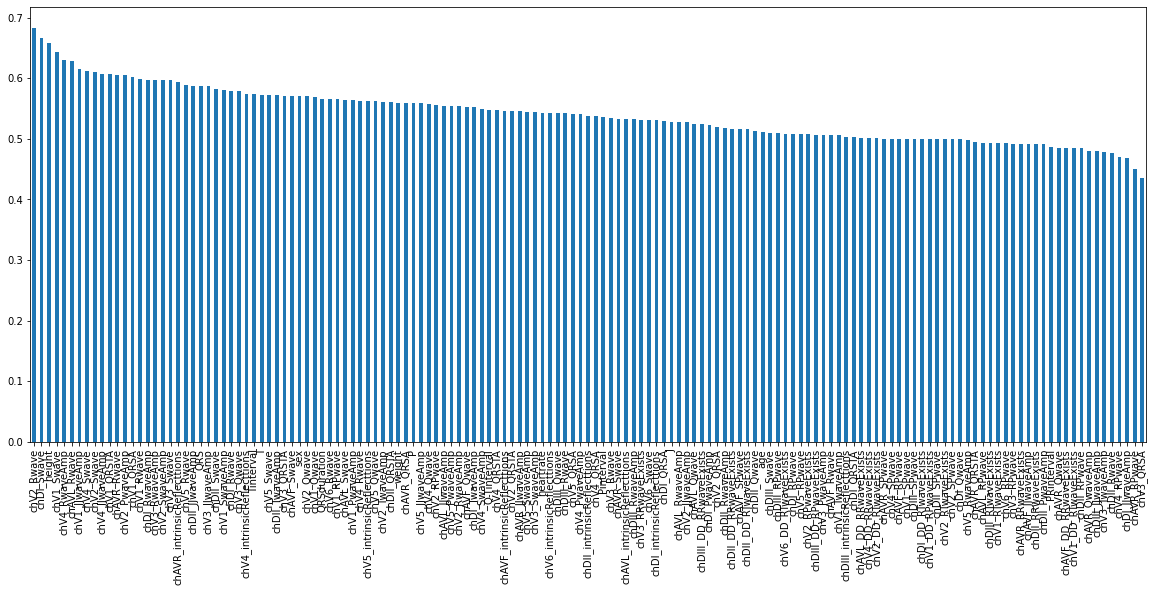

In [ ]:
X_train_univariate, X_test_univariate, y_train_univariate, y_test_univariate = removeUnivariate(X_train_corr, X_test_corr, y_train, y_test)
print(X_train_univariate.shape)
accKnn.append(accuracyKnn(X_train_univariate, X_test_univariate, y_train_univariate, y_test_univariate))
accDecision.append(accuracyDecision(X_train_univariate, X_test_univariate, y_train_univariate, y_test_univariate))
accSVM.append(accuracySVM(X_train_univariate, X_test_univariate, y_train_univariate, y_test_univariate))
accRF.append(accuracyRF(X_train_univariate, X_test_univariate, y_train_univariate, y_test_univariate))
accLoR.append(accuracyLoR(X_train_univariate, X_test_univariate, y_train_univariate, y_test_univariate))

In [ ]:
X_train_uni_copy = X_train_univariate.copy()
X_test_uni_copy = X_test_univariate.copy()

Mutual Information

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import minmax_scale

mm_X=minmax_scale(X_train_univariate, feature_range=(0, 1), axis=0, copy=True)
mm_X = pd.DataFrame(mm_X)
mm_X1=minmax_scale(X_test_univariate, feature_range=(0, 1), axis=0, copy=True)
mm_X1 = pd.DataFrame(mm_X1)

sel_ = SelectPercentile(mutual_info_classif, percentile=10).fit(mm_X, y_train_univariate)
features = sel_.get_support()
sel_features = [ f for i,f in enumerate(mm_X.columns) if features[i]]
print(sel_features)
print(len(sel_features))

[9, 12, 45, 54, 58, 72, 73, 74, 87, 97, 101, 107]
12


In [ ]:
mm_X.drop(labels=sel_features, axis=1, inplace=True)
mm_X1.drop(labels=sel_features, axis=1, inplace=True)
print(mm_X.shape)

(316, 100)


In [ ]:
accKnn.append(accuracyKnn(mm_X, mm_X1, y_train_univariate, y_test_univariate))
accDecision.append(accuracyDecision(mm_X, mm_X1, y_train_univariate, y_test_univariate))
accSVM.append(accuracySVM(mm_X, mm_X1, y_train_univariate, y_test_univariate))
accRF.append(accuracyRF(mm_X, mm_X1, y_train_univariate, y_test_univariate))
accLoR.append(accuracyLoR(mm_X, mm_X1, y_train_univariate, y_test_univariate))

KNN: 0.6470588235294118
DT: 0.6029411764705882
SVM: 0.6397058823529411
RF: 0.5073529411764706
LoR: 0.6764705882352942


Embedded(Lasso)

In [ ]:
X_train_lasso, X_test_lasso = removeLasso(X_train_uni_copy, X_test_uni_copy, y_train, y_test)
print(X_train_lasso.shape) #reduced to 12
accKnn.append(accuracyKnn(X_train_lasso,X_test_lasso,y_train,y_test))
accDecision.append(accuracyDecision(X_train_lasso,X_test_lasso,y_train,y_test))
accSVM.append(accuracySVM(X_train_lasso, X_test_lasso, y_train, y_test))
accRF.append(accuracyRF(X_train_lasso, X_test_lasso, y_train, y_test))
accLoR.append(accuracyLoR(X_train_lasso, X_test_lasso, y_train, y_test))

(316, 83)
KNN: 0.625
DT: 0.7205882352941176
SVM: 0.7205882352941176
RF: 0.6985294117647058
LoR: 0.6838235294117647


Wrapper

Step forward feature selection

In [ ]:
# step forward feature selection

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs = SFS(RandomForestClassifier(n_jobs=-1), 
           k_features=7, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=3)

sfs = sfs.fit(X_train_lasso, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:  1.3min finished

[2021-09-15 13:08:35] Features: 1/7 -- score: 0.6827963368772875[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:  1.3min finished

[2021-09-15 13:09:52] Features: 2/7 -- score: 0.7533496300872832[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.3min finished

[2021-09-15 13:11:08] Features: 3/7 -- score: 0.8044354889169202[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [ ]:
feat = X_train_lasso.columns[list(sfs.k_feature_idx_)]
print(feat)
X_train_sfs = sfs.transform(X_train_lasso)
X_test_sfs = sfs.transform(X_test_lasso)

Index(['T', 'heartrate', 'chAVF_Qwave', 'chV1_RPwave', 'chV3_Swave',
       'chV5_JJwaveAmp', 'chV5_SwaveAmp'],
      dtype='object')


In [ ]:
accKnn.append(accuracyKnn(X_train_sfs,X_test_sfs,y_train,y_test))
accDecision.append(accuracyDecision(X_train_sfs,X_test_sfs,y_train,y_test))
accSVM.append(accuracySVM(X_train_sfs,X_test_sfs, y_train, y_test))
accRF.append(accuracyRF(X_train_sfs,X_test_sfs, y_train, y_test))
accLoR.append(accuracyLoR(X_train_sfs,X_test_sfs, y_train, y_test))

KNN: 0.7573529411764706
DT: 0.7132352941176471
SVM: 0.6544117647058824
RF: 0.7794117647058824
LoR: 0.6397058823529411


In [ ]:
classifierrf=RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
classifierrf.fit(X_train_sfs,y_train)
y_predrf = classifierrf.predict(X_test_sfs)
accuracy3 = accuracy_score(y_test, y_predrf)
print("RF: {}".format(accuracy3))
y_pred = y_predrf.tolist()
print('{}'.format(y_pred))

RF: 0.7794117647058824
[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


Step backward feature selection

In [ ]:
sbs = SFS(RandomForestClassifier(n_jobs=-1), 
           k_features=7, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

sbs = sbs.fit(np.array(X_train_lasso), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
feat = X_train_lasso.columns[list(sbs.k_feature_idx_)]
print(feat)
print('Total optimal features: {}'.format(len(feat)))
X_train_sbs = sbs.transform(X_train_lasso)
X_test_sbs = sbs.transform(X_test_lasso)

Index(['sex', 'height', 'weight', 'Tinterval', 'Pinterval', 'QRS', 'T', 'P',
       'J', 'heartrate', 'chDI_Rwave', 'chDI_Swave',
       'chDI_intrinsicReflecttions', 'chDII_Qwave', 'chDII_Swave',
       'chDII_intrinsicReflecttions', 'chDII_DD_RRwaveExists', 'chDIII_Qwave',
       'chDIII_Rwave', 'chDIII_Swave', 'chDIII_RPwave',
       'chDIII_intrinsicReflecttions', 'chDIII_DD_RRwaveExists',
       'chDIII_DD_RPwaveExists', 'chAVR_Swave', 'chAVR_intrinsicReflecttions',
       'chAVL_Qwave', 'chAVL_Rwave', 'chAVL_Swave',
       'chAVL_intrinsicReflecttions', 'chAVF_Qwave', 'chAVF_Rwave',
       'chAVF_Swave', 'chAVF_SPwave', 'chAVF_intrinsicReflecttions',
       'chV1_Qwave', 'chV1_Rwave', 'chV1_RPwave', 'chV2_Qwave', 'chV2_Rwave',
       'chV2_Swave', 'chV2_RPwave', 'chV2_RPwaveExists',
       'chV2_DD_RTwaveExists', 'chV3_Qwave', 'chV3_Swave', 'chV3_RRwaveExists',
       'chV4_intrinsicReflecttions', 'chV5_Qwave', 'chV5_Rwave', 'chV5_Swave',
       'chV5_RPwave', 'chV5_intrinsicRefl

In [ ]:
accKnn.append(accuracyKnn(X_train_sbs,X_test_sbs,y_train,y_test))
accDecision.append(accuracyDecision(X_train_sbs,X_test_sbs,y_train,y_test))
accSVM.append(accuracySVM(X_train_sbs,X_test_sbs, y_train, y_test))
accRF.append(accuracyRF(X_train_sbs,X_test_sbs, y_train, y_test))
accLoR.append(accuracyLoR(X_train_sbs,X_test_sbs, y_train, y_test))

KNN: 0.625
DT: 0.7205882352941176
SVM: 0.7205882352941176
RF: 0.6985294117647058
LoR: 0.6838235294117647


Analysis

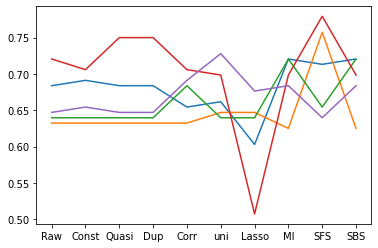

In [ ]:
label = ['Raw', 'Const', 'Quasi', 'Dup', 'Corr', 'uni' ,'Lasso','MI','SFS','SBS']
plt.plot(label,accDecision) 
plt.plot(label,accKnn) #constant accuracy till Lasso
plt.plot(label,accSVM)
plt.plot(label,accRF)
plt.plot(label,accLoR)

In [ ]:
from IPython.display import display

dict= {'Type':['Raw data','Filter based(basic)', 'Filter based (correlated)', 'Statistical','Embedded', 'Wrapper'], 

        'Steps' : ['None','Remove Constant, Quasi Constant & Duplicated Features', 'Remove Correlated features (Spearman)', 'Univariate','Lasso','Sequential Feature Selection'], 

        'KNN' : [63.23,63.23,63.23,64.70,62.5,75.73],
        'DT'    :[68.38,68.38,65.44,66.17,72.05,71.32],
        'SVM'   :[63.97,63.97,68.38,63.97,72.05,65.44],
        'RF'    :[72.05,75,70.58,69.85,69.85,77.94],
        'LoR'   :[64.70,64.70,69.11,72.79,68.38,63.97]}

df = pd.DataFrame(dict)  
display(df)

,Type,Steps,KNN,DT,SVM,RF,LoR
0,Raw data,None,63.23,68.38,63.97,72.05,64.70
1,Filter based(basic),"Remove Constant, Quasi Constant & Duplicated F...",63.23,68.38,63.97,75.00,64.70
2,Filter based (correlated),Remove Correlated features (Spearman),63.23,65.44,68.38,70.58,69.11
3,Statistical,Univariate,64.70,66.17,63.97,69.85,72.79
4,Embedded,Lasso,62.50,72.05,72.05,69.85,68.38
5,Wrapper,Sequential Feature Selection,75.73,71.32,65.44,77.94,63.97


In [ ]:
# Mean roc_auc_score

auc = np.round(roc_auc_score(y_true,y_pred),3)

print('Mean Auc score for our data is {}'.format(auc))

Mean Auc score for our data is 0.784
